<a href="https://colab.research.google.com/github/eecoubrough/Keras_Assignment/blob/main/Part_1_binary.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Deep Learning Medical Image Analysis Example
A simple convolutional neural network model trained using a simple pathology image dataset.

To use GPU acceleration make sure to change your runtime type in Google Colab to GPU.

## Python Imports
This section will load the necessary python packages to the instance.

In [1]:
# Built-in Imports
import random

In [2]:
# Library Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay

In [28]:
# Keras Imports
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras import regularizers
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import get_file, to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator

## Dataset Downloader
This section will download the BloodMNIST dataset as a NumPy array object to the Google Colab instance. Note that the dataset does need to be redownloaded every time an instance is created.

In [4]:
# The dataset selected is PneumoniaMNIST
# If desired, a different MedMNIST dataset could be used simply by specifying the desired dataset name.
DATA_NAME = "PneumoniaMNIST"

In [5]:
# Retrieves the dataset from GitHub
!wget https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
from info import INFO
data = INFO[DATA_NAME.lower()]

--2024-03-31 18:27:56--  https://raw.githubusercontent.com/MedMNIST/MedMNIST/main/medmnist/info.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 27766 (27K) [text/plain]
Saving to: ‘info.py’

info.py             100%[===================>]  27.12K  --.-KB/s    in 0.002s  

2024-03-31 18:27:57 (10.9 MB/s) - ‘info.py’ saved [27766/27766]



In [6]:
# Downloads the dataset file hosted on Zenodo.
file_path = get_file(fname="dataset.npz",
                     origin=data["url"],
                     md5_hash=data["MD5"])

4170669/4170669 [==============================] - 1s 0us/step


In [7]:
# Loads the downloaded NumPy object, saving it to the variable 'dataset'.
dataset = np.load(file_path)

# Gets the training images and labels from the NumPy object.
train_x = dataset["train_images"]
# Adds an extra new dimension to the training images array to make it compatible with CNNs.
    # This is necessary because the dataset is greyscale images are represented by a 2D array, but CNNs require a 3D input tensor.
    # By adding a new dimension with size 1, it explicitly specifies that there is just one channel (for grayscale) in addition to height and width.
train_x = np.expand_dims(train_x, axis=-1)
train_y = dataset["train_labels"]

# Gets the validation images and labels from the NumPy object.
val_x = dataset["val_images"]
# Adds an extra new dimension to the training images array to make it compatible with CNNs.
val_x = np.expand_dims(val_x, axis=-1)
val_y = dataset["val_labels"]

# Gets the testing images and labels from the NumPy object.
test_x = dataset["test_images"]
# Adds an extra new dimension to the training images array to make it compatible with CNNs.
test_x = np.expand_dims(test_x, axis=-1)
test_y = dataset["test_labels"]

## Data Exploration
In this section we have a look at our data, their distributions to see if it is ready to be used within our machine learning algorithm.

In [8]:
# Print the shape of one of the images in your dataset to ensure the images are in the expected shape format.
print(train_x[0].shape)

(28, 28, 1)


In [9]:
# Declares a list of labels.
labels = list(data["label"].values()) + ["total"]

# Gets the counts for each label in each of our datasets.
_, train_counts = np.unique(train_y, return_counts=True)
_, val_counts = np.unique(val_y, return_counts=True)
_, test_counts = np.unique(test_y, return_counts=True)

# Prints the counts for each label from each dataset (used to check the distributions of data in each of the eight classes to ensure there is no unexpected discepencies).
print(pd.DataFrame(list(zip(np.append(train_counts, [sum(train_counts)]),
                            np.append(val_counts, [sum(val_counts)]),
                            np.append(test_counts, [sum(test_counts)]))),
                   index=labels, columns=["Train", "Val", "Test"]))

           Train  Val  Test
normal      1214  135   234
pneumonia   3494  389   390
total       4708  524   624


4487: pneumonia


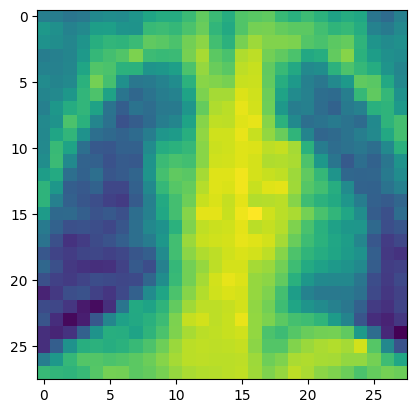

In [10]:
# Displays a random image from training dataset.
index = random.randint(0, len(train_x))
print(f"{index}: {labels[train_y[index][0]]}")
plt.imshow(train_x[random.randint(0, len(train_x))])

## Data Processing
In this section we will create a data loader for algorithm that will dynamiclly load and augment the data when needed.

In [11]:
# Defines the data generator that will be used to augment the images as they are loaded.
data_generator = ImageDataGenerator(featurewise_center=True,
                                    featurewise_std_normalization=True,
                                    horizontal_flip=True,
                                    vertical_flip=True)

In [12]:
data_generator.fit(np.append(train_x, val_x, 0))



---
# **Part 1 - Covnet with same architechture and training regime**


## Model Definition


In [13]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the first convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Defines the second convolutional layer with max pooling.
conv_2 = layers.Conv2D(filters=32, kernel_size=3, activation="relu")(pool_1)
pool_2 = layers.MaxPool2D(pool_size=(2, 2))(conv_2)

# Flattens the outputs of the convolutional layers into a one dimensional array.
flatten = layers.Flatten()(pool_2)

# Defines the output layer of the model a number of output nodes equal to the number of classes.
output = layers.Dense(units=1, activation="sigmoid")(flatten)

# Initilises the defined model and prints summary of the model.
model_1 = Model(inputs=input, outputs=output, name="Model_1")
model_1.summary()

Model: "Model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2  (None, 13, 13, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 5, 5, 32)          0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 800)               0   

## Model Training



In [14]:
# Define the parameters used during training.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [15]:
# Defines the optimiser used to adjust the model weights and compiles the model.
optimiser = SGD(learning_rate=LEARNING_RATE)
model_1.compile(optimizer=optimiser, loss="binary_crossentropy", metrics=["accuracy"])

In [16]:
# Use data generator to pass the training and validation data to the model to train it.
history = model_1.fit(data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE),
                    steps_per_epoch=len(train_x) / BATCH_SIZE,
                    validation_data=data_generator.flow(val_x, val_y, batch_size=BATCH_SIZE),
                    validation_steps=len(val_x) / BATCH_SIZE,
                    epochs=NUM_EPOCHS)

Epoch 1/10
73/73 [==============================] - 14s 147ms/step - loss: 0.6531 - accuracy: 0.6982 - val_loss: 0.6295 - val_accuracy: 0.7424
Epoch 2/10
73/73 [==============================] - 4s 57ms/step - loss: 0.6123 - accuracy: 0.7421 - val_loss: 0.5965 - val_accuracy: 0.7424
Epoch 3/10
73/73 [==============================] - 3s 39ms/step - loss: 0.5898 - accuracy: 0.7421 - val_loss: 0.5816 - val_accuracy: 0.7424
Epoch 4/10
73/73 [==============================] - 3s 39ms/step - loss: 0.5721 - accuracy: 0.7421 - val_loss: 0.5650 - val_accuracy: 0.7424
Epoch 5/10
73/73 [==============================] - 4s 48ms/step - loss: 0.5560 - accuracy: 0.7421 - val_loss: 0.5516 - val_accuracy: 0.7424
Epoch 6/10
73/73 [==============================] - 3s 39ms/step - loss: 0.5430 - accuracy: 0.7421 - val_loss: 0.5386 - val_accuracy: 0.7424
Epoch 7/10
73/73 [==============================] - 4s 53ms/step - loss: 0.5292 - accuracy: 0.7421 - val_loss: 0.5285 - val_accuracy: 0.7424
Epoch 8/10


## Plot Learning Curves
This is where we visualise the training of the model.

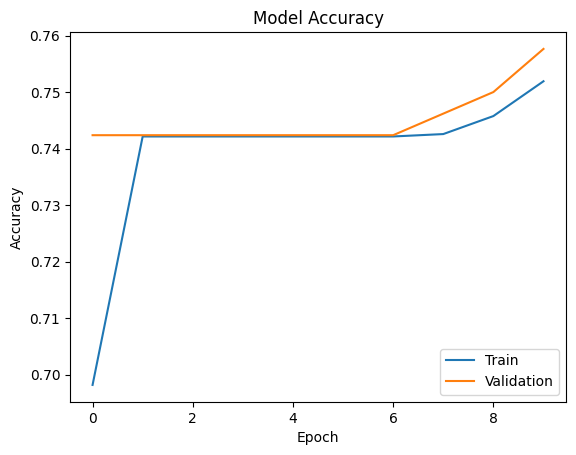

In [17]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')
plt.show()

The training accuracy is moderately low at the beginning, increasing rapidly before flattening out at approximately 3.5 epochs. This indicates that the addition of more training examples does not improve the models performance on the training dataset.

---



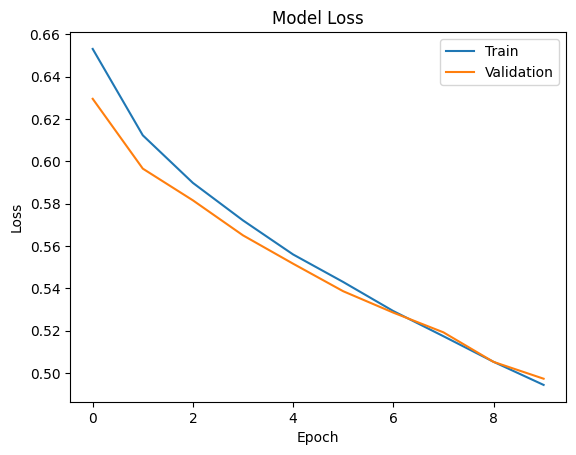

In [18]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()



---
#**Part 2 - A network with only dense layers**


## Model Definition


This model has been designed to have a similar number of parameters to model_1. This was achieved by adjusting the number of units in each of the dense layers.

> Model_1 has a total of 10369 parameters, and model_2 has 10371 parameters.







In [19]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Flattens the outputs of the input layer into a 1D array.
flatten = layers.Flatten()(input)

# Dense layer 1 with 13 units and ReLU activation.
dense_1 = layers.Dense(units=13, activation="relu")(flatten)

# Dense layer 2 with 11 units and ReLU activation.
dense_2 = layers.Dense(units=11, activation="relu")(dense_1)

# Defines the output layer with a single node and sigmoid activation for binary classification.
output = layers.Dense(units=1, activation="sigmoid")(dense_2)

# Initializes the defined model with the input and output layers.
model_2 = Model(inputs=input, outputs=output, name="Model_2")

# Print the summary of the model.
model_2.summary()


Model: "Model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten_1 (Flatten)         (None, 784)               0         
                                                                 
 dense_1 (Dense)             (None, 13)                10205     
                                                                 
 dense_2 (Dense)             (None, 11)                154       
                                                                 
 dense_3 (Dense)             (None, 1)                 12        
                                                                 
Total params: 10371 (40.51 KB)
Trainable params: 10371 (40.51 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


## Model Training
This is where we define the training options and then train the model.


In [20]:
# Defines the parameters used during training.
# Since the training regime is to be the same as for model_1, these parameters are the same as they were previously.
BATCH_SIZE = 64
NUM_EPOCHS = 10
LEARNING_RATE = 0.001

In [21]:
# Define the optimizer with the above specified learning rate.
optimizer = SGD(learning_rate=LEARNING_RATE)

# Compile the model with the above defined optimizer, binary crossentropy loss, and accuracy metric.
model_2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [22]:
# Train the model using training data generated in batches by the data generator.
history = model_2.fit(
    data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE),
    # Calculate steps per epoch based on the number of training samples and batch size.
    steps_per_epoch=len(train_x) / BATCH_SIZE,
    # Use validation data generated in batches by the data generator.
    validation_data=data_generator.flow(val_x, val_y, batch_size=BATCH_SIZE),
    # Calculate validation steps based on the number of validation samples and batch size.
    validation_steps=len(val_x) / BATCH_SIZE,
    # Number of epochs to train the model.
    epochs=NUM_EPOCHS
)


Epoch 1/10
73/73 [==============================] - 1s 9ms/step - loss: 0.5848 - accuracy: 0.7315 - val_loss: 0.5706 - val_accuracy: 0.7405
Epoch 2/10
73/73 [==============================] - 1s 8ms/step - loss: 0.5483 - accuracy: 0.7521 - val_loss: 0.5318 - val_accuracy: 0.7405
Epoch 3/10
73/73 [==============================] - 1s 7ms/step - loss: 0.5211 - accuracy: 0.7559 - val_loss: 0.5076 - val_accuracy: 0.7729
Epoch 4/10
73/73 [==============================] - 1s 7ms/step - loss: 0.4897 - accuracy: 0.7638 - val_loss: 0.4903 - val_accuracy: 0.7653
Epoch 5/10
73/73 [==============================] - 1s 7ms/step - loss: 0.4681 - accuracy: 0.7721 - val_loss: 0.4662 - val_accuracy: 0.7748
Epoch 6/10
73/73 [==============================] - 1s 7ms/step - loss: 0.4482 - accuracy: 0.7867 - val_loss: 0.4431 - val_accuracy: 0.7882
Epoch 7/10
73/73 [==============================] - 1s 7ms/step - loss: 0.4322 - accuracy: 0.7901 - val_loss: 0.4319 - val_accuracy: 0.7977
Epoch 8/10
73/73 [==

## Plot Learning Curves
This is where we visualise the training of the model.

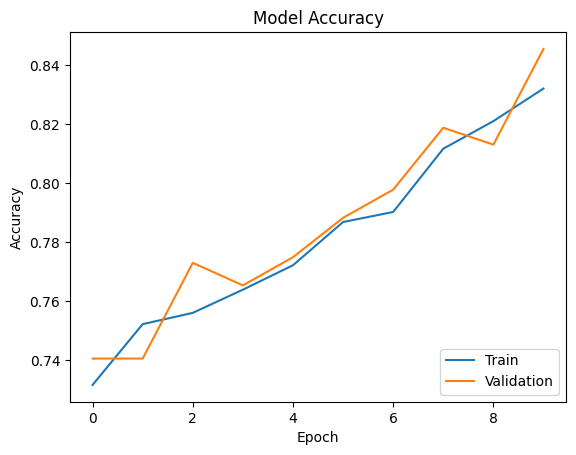

In [23]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Add plot title.
plt.title('Model Accuracy')

# Add plot axes labels.
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='lower right')

# Show the plot.
plt.show()

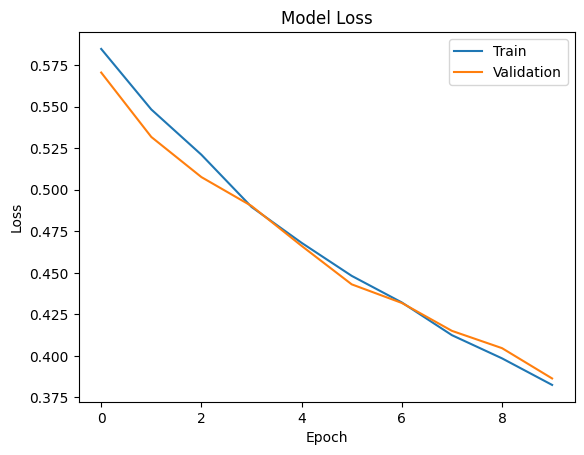

In [24]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Add plot title.
plt.title('Model Loss')

# Add plot axes labels.
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plot.
plt.show()


---
#**Part 3 - A deep network of my own design**


## Data Augmentation

In [25]:
# Defines the data generator for augmenting images during loading.
data_generator = ImageDataGenerator(featurewise_center=True,  # Centers the pixel values of each image around zero.
                                    featurewise_std_normalization=True,     # Standardizes the pixel values of each image.
                                    horizontal_flip=True,     # Randomly flips images horizontally.
                                    vertical_flip=True,     # Randomly flips images vertically.
                                    rotation_range=10,     # Randomly rotates images within the specified range.
                                    width_shift_range=0.1,     # Randomly shifts images horizontally within the specified range.
                                    height_shift_range=0.1,     # Randomly shifts images vertically within the specified range.
                                    )


In [26]:
data_generator.fit(np.append(train_x, val_x, 0))

## Model Definition
In this section we will define the neural network arcitecture.

In [29]:
# Define the input layer of the model with the size of an image.
input = layers.Input(shape=train_x[0].shape)

# Defines the convolutional layer with max pooling.
conv_1 = layers.Conv2D(filters=32, kernel_size=3, activation="relu", kernel_regularizer=regularizers.l2(0.01))(input)
pool_1 = layers.MaxPool2D(pool_size=(2, 2))(conv_1)

# Flattens the outputs of the convolutional layers into a one-dimensional array.
flatten = layers.Flatten()(pool_1)

# Dense layer
dense = layers.Dense(units=16, activation="relu")(flatten)

# Output layer:
# Single node with sigmoid activation for binary classification.
# L2 regularization with strength 0.01 is applied to kernel weights.
output = layers.Dense(units=1, activation="sigmoid", kernel_regularizer=regularizers.l2(0.01))(dense)

# Initializes the defined model.
model_3 = Model(inputs=input, outputs=output, name="Model_3")
# Print the model summary.
model_3.summary()

Model: "Model_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 13, 13, 32)        0         
 g2D)                                                            
                                                                 
 flatten_2 (Flatten)         (None, 5408)              0         
                                                                 
 dense_4 (Dense)             (None, 16)                86544     
                                                                 
 dense_5 (Dense)             (None, 1)                 17        
                                                           

## Model Training
This is where we define the training options and then train the model.

Through testing different values for the training parameters, I determined that a smaller batch size and more epochs was optimum.


In [30]:
# Defines the parameters used during training.
BATCH_SIZE = 32 #Batch size should always be a power of 2 GPU allocation purposes (quicker as no additional calculations required by the computer)
NUM_EPOCHS = 20
LEARNING_RATE = 0.001

In [35]:
# Define the optimizer with the above specified learning rate.
optimizer = SGD(learning_rate=LEARNING_RATE)

# Compile the model with the above defined optimizer, binary crossentropy loss, and accuracy metric.
model_2.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=["accuracy"])

In [36]:
# Train the model using training data generated in batches by the data generator.
history = model_3.fit(
    data_generator.flow(train_x, train_y, batch_size=BATCH_SIZE),
    # Calculate steps per epoch based on the number of training samples and batch size.
    steps_per_epoch=len(train_x) / BATCH_SIZE,
    # Use validation data generated in batches by the data generator.
    validation_data=data_generator.flow(val_x, val_y, batch_size=BATCH_SIZE),
    # Calculate validation steps based on the number of validation samples and batch size.
    validation_steps=len(val_x) / BATCH_SIZE,
    # Number of epochs to train the model.
    epochs=NUM_EPOCHS
)


Epoch 1/20
147/147 [==============================] - 7s 45ms/step - loss: 0.6895 - accuracy: 0.6523 - val_loss: 0.6369 - val_accuracy: 0.7424
Epoch 2/20
147/147 [==============================] - 3s 23ms/step - loss: 0.6066 - accuracy: 0.7424 - val_loss: 0.5998 - val_accuracy: 0.7424
Epoch 3/20
147/147 [==============================] - 5s 32ms/step - loss: 0.5720 - accuracy: 0.7445 - val_loss: 0.5718 - val_accuracy: 0.7443
Epoch 4/20
147/147 [==============================] - 3s 23ms/step - loss: 0.5398 - accuracy: 0.7559 - val_loss: 0.5328 - val_accuracy: 0.7710
Epoch 5/20
147/147 [==============================] - 3s 23ms/step - loss: 0.5158 - accuracy: 0.7814 - val_loss: 0.5185 - val_accuracy: 0.7977
Epoch 6/20
147/147 [==============================] - 5s 31ms/step - loss: 0.4891 - accuracy: 0.8122 - val_loss: 0.4778 - val_accuracy: 0.8302
Epoch 7/20
147/147 [==============================] - 3s 23ms/step - loss: 0.4601 - accuracy: 0.8362 - val_loss: 0.4600 - val_accuracy: 0.8302

## Plot Learning Curves
This is where we visualise the training of the model.

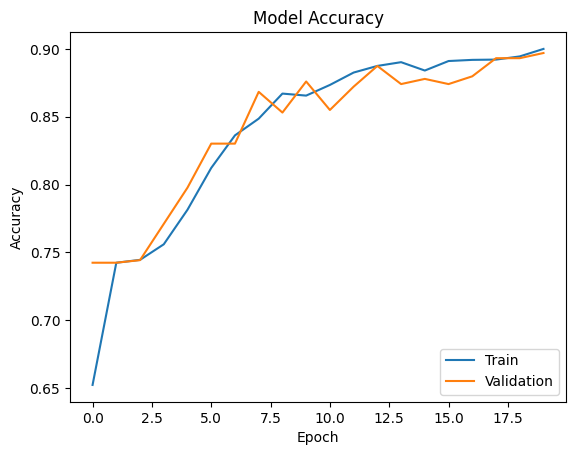

In [37]:
# Plots the training and validation accuracy over the number of epochs.
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])

# Add plot title.
plt.title('Model Accuracy')

# Add plot axes labels.
plt.ylabel('Accuracy')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='lower right')

# Show the plot.
plt.show()

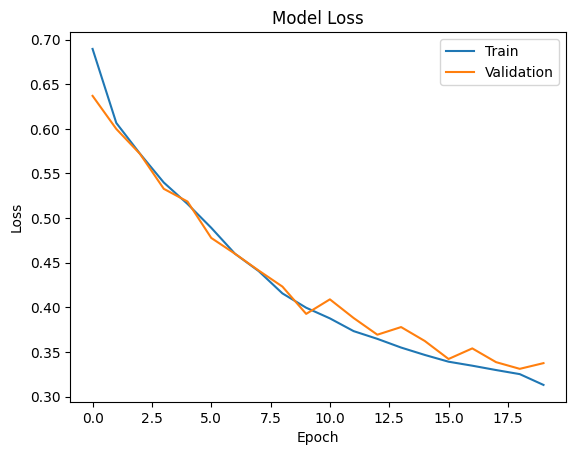

In [38]:
# Plots the training and validation loss over the number of epochs.
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

# Add plot title.
plt.title('Model Loss')

# Add plot axes labels.
plt.ylabel('Loss')
plt.xlabel('Epoch')

# Add plot legend to distinguish between training and validation accuracy lines.
plt.legend(['Train', 'Validation'], loc='upper right')

# Show the plot.
plt.show()